In [178]:
import numpy as np
# import scipy.stats as ss
# from scipy.spatial import distance_matrix
import random
import matplotlib.pyplot as plt
import pandas as pd
# from sklearn.cluster import SpectralClustering
from tqdm import tqdm

In [179]:
INPUT_PATH="/mnt/geofflab/SNP_barcoding/Lvar_annotations_v3_Jan2021/transcripts.csv"

In [26]:
# import sys
# print(sys.version)

3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]


In [174]:
# df = pd.read_csv(INPUT_PATH)
# print(np.sort(np.unique(df["chromosome"])))
# print()
# df_chr13_sorted = df[df["chromosome"] == 13].sort_values(by=["start"])
# print(df_chr13_sorted.head(1).index[0])
# print()
# print(df_chr13_sorted.tail())
# print(df_chr13_sorted["start"].iloc[0])
# print(df_chr13_sorted["end"].iloc[-1])
# print(range(df_chr13_sorted["start"].iloc[0],df_chr13_sorted["end"].iloc[-1]))
# print()
# chiasma_point = random.choice(range(df_chr13_sorted["start"].iloc[0],df_chr13_sorted["end"].iloc[-1]))
# print(f"chiasma point: {chiasma_point}")
# print()
# for idx,transcript_entry in df_chr13_sorted.iterrows():
#     gene,chromosome,start,end,direction,sequence = transcript_entry
#     if chiasma_point < start: 
#         print(str(idx)+"\n")
#         print(transcript_entry)
#         if chiasma_point in range(start,end+1):
#             print("\nChiasma point in transcript!")
#         break

# plt.hist(x=df_chr13_sorted["start"])
# plt.show()
# plt.hist(x=df_chr13_sorted["end"])
# plt.show()

# gene,chromosome,start,end,direction,sequence = df.loc[1,:]
# print(gene,chromosome,start,end,direction)
# # TODO: why these don't match
# print(start,end,end-start)
# print(len(sequence))
# print(sequence)

In [181]:
heterozygosity = 0.0045
alphabet = {"A":0, "C":1, "G":2, "T":3}
genotypes = {
    "AA":0, "AC":1, "AG":2, "AT":3, 
    "CA":1, "CC":4, "CG":5, "CT":6,
    "GA":2, "GC":4, "GG":7, "GT":8, 
    "TA":3, "TC":6, "TG":8, "TT":9,
}

class EmbryoSequenceSimulator:
    def __init__(self, input_df, n_embryos):
        
        # pd data frame
        self.input_df = input_df # cols: gene,chromosome,start,end,direction,sequence
        self.n_embryos = n_embryos
        
        # Number of cells that can be harvested from embryo
        self.avg_harvested_cells = 10
        self.sd_harvested_cells = 1
        self.alphabet = {"A":0, "C":1, "G":2, "T":3}
        
        # Global parental chromatid maps
        self.m0_chromatid = None
        self.m1_chromatid = None
        self.p0_chromatid = None
        self.p1_chromatid = None
        
    def global_seeding(self, heterozygosity):
        """
        Uniform seeding of SNP locations for each gene with frequency according to heterozygosity.
        Parental chromatid seeding (2 chromatids from mother, 2 chromatids from father)
        """
        
        # Setting SNP positions for each transcript in input_df
        snp_map = {}
        for idx,transcript_entry in self.input_df.iterrows():
            gene,chromosome,start,end,direction,sequence = transcript_entry

            # TODO: check why len(sequence) != end-start
            # TODO: do we need to incorporate direction at all?
            
            # N = end-start # length of transcript
            N = len(sequence)
            num_snps = round(N*heterozygosity)
            snp_positions = np.sort(random.sample(range(N),num_snps))
            snp_map[idx] = snp_positions
        
        # Setting parental chromatid maps
        for parent in ["m0","m1","p0","p1"]:
            parental_chromatid = {} # map: idx of transcript entry -> seeded sequence
            for idx,snp_positions in snp_map.items():
                gene,chromosome,start,end,direction,sequence = self.input_df.loc[idx,:]
                
                # TODO: add transition probability wrt reference (transcript/chromosome specific, 
                #       look at Kramer paper)
                
                snp_profile = {locus:random.choice(list(self.alphabet.keys())) for locus in snp_positions}
                
                # convert reference seq string into list
                sequence_list = [char for char in sequence]
                for locus,char in snp_profile.items():
                    sequence_list[locus] = char
                parental_chromatid[idx] = "".join(sequence_list)
            
            # Assign seeded parental chromatid to its class field (global over all embryos)
            if parent == "m0":
                self.m0_chromatid = parental_chromatid
            elif parent == "m1":
                self.m1_chromatid = parental_chromatid
            elif parent == "p0":
                self.p0_chromatid = parental_chromatid
            elif parent == "p1":
                self.p1_chromatid = parental_chromatid
                
        return snp_map
    
    def embryo_population_simulation(self):
        """
        Simulating SNP profile for each embryo across all transcript entries in input_df.
        For this simulator, not explicitly generating scRNA-seq reads for each embryo (reduces space)
        """
        
        # map: idx of transcript entry -> list of snp positions
        snp_map = self.global_seeding(heterozygosity)
        
        population_profile = []
        for _ in range(self.n_embryos):
            
            # each entry a list of genotypes for an embryo across all transcripts
            snp_profile = self.determine_embryo_genotype(snp_map)
            
            # Harvest some number of cells, which will theoretically have identical SNP profiles
            n_harvested_cells = round(np.random.normal(self.avg_harvested_cells,self.sd_harvested_cells))
            for __ in range(n_harvested_cells):
                population_profile.append(snp_profile)
                
        return np.array(population_profile)
    
    def determine_embryo_genotype(self, snp_map):
        """
        Simulate array containing genotypes over all transcripts 
        (concatenated into single list)
        """
        
        # state (genotype) across all transcripts
        snp_genotypes = []
        
        # map: idx of transcript entry -> sequence after homologous recombination
        m_chromatid,p_chromatid = self.simulate_embryo_sequence(snp_map)
        
        # For simulated embryo sequences, visit each SNP and characterize its genotype
        for idx,snp_positions in snp_map.items():
            m_sequence,p_sequence = m_chromatid[idx],p_chromatid[idx]
            for locus in snp_positions:
                snp_genotype = "".join([m_sequence[locus],p_sequence[locus]])
                snp_genotypes.append(genotypes[snp_genotype])
                
        return snp_genotypes
                
    def simulate_embryo_sequence(self,snp_map):
        """
        Given seeded parental chromatids and a map of SNP locations for each transcript,
        simulate embryo sequences
        """
        
        updated_m0,updated_m1 = {},{}
        updated_p0,updated_p1 = {},{}
        
        for parent in ["mother","father"]:
            
            # Consider homologous recombination with respect to each chromosome
            for chr_num in np.sort(np.unique(df["chromosome"])):
                
                # Subset df for specific chr, sorted by start position 
                chr_df = self.input_df[self.input_df["chromosome"] == chr_num].sort_values(by=["start"])
                
                # Chiasma point chosen over range of transcripts reads
                
                # TODO: is it necessary to exclude certain regions like centromeres (or include more regions)
                transcript_range = range(chr_df["start"].iloc[0], chr_df["start"].iloc[-1]+len(chr_df["sequence"].iloc[-1])) # range(chr_df["start"].iloc[0],chr_df["end"].iloc[-1])
                chiasma = random.choice(transcript_range)
                chiasma_flag = 1 # 1 means chiasma has not been reached; 0 means passed chiasma
                for idx,transcript_entry in chr_df.iterrows():
                    gene,chromosome,start,end,direction,sequence = transcript_entry

                    if chiasma <= start and chiasma_flag == 1:
                        chiasma_flag = 0
                                         
                        # Case where chiasma point lies in the middle of a transcript read
                        if chiasma in range(start,start+len(sequence)):
                            if parent == "mother":
                                updated_m0[idx] = self.m0_chromatid[idx][:chiasma]+self.m1_chromatid[idx][chiasma:]
                                updated_m1[idx] = self.m1_chromatid[idx][:chiasma]+self.m0_chromatid[idx][chiasma:]
                            else: # parent == "father"
                                updated_p0[idx] = self.p0_chromatid[idx][:chiasma]+self.p1_chromatid[idx][chiasma:]
                                updated_p1[idx] = self.p1_chromatid[idx][:chiasma]+self.p0_chromatid[idx][chiasma:]
                            continue
                    
                    if chiasma_flag == 1: # Before chiasma point has been reached
                        if parent == "mother":
                            updated_m0[idx] = self.m0_chromatid[idx]
                            updated_m1[idx] = self.m1_chromatid[idx]
                        else: # parent == "father"
                            updated_p0[idx] = self.p0_chromatid[idx]
                            updated_p1[idx] = self.p1_chromatid[idx]
                    else: # After chiasma point has been reached
                        if parent == "mother":
                            updated_m0[idx] = self.m1_chromatid[idx]
                            updated_m1[idx] = self.m0_chromatid[idx]
                        else: # parent == "father"
                            updated_p0[idx] = self.p1_chromatid[idx]
                            updated_p1[idx] = self.p0_chromatid[idx]
        
        # Choose pairs of parental chromatids that get inherited by embryo
        m_chromatid = updated_m0 if random.random() <= 0.5 else updated_m1
        p_chromatid = updated_p0 if random.random() <= 0.5 else updated_p1
        
        return m_chromatid,p_chromatid
                
    

In [182]:
n_embryos = 100
df = pd.read_csv(INPUT_PATH)
df = df.dropna()
# df = df.loc[:100,:]
df = df.sample(250)
simulator = EmbryoSequenceSimulator(df, n_embryos)
X = simulator.embryo_population_simulation()
print(X.shape)
print(X)

(1008, 2151)
[[5 7 1 ... 5 0 1]
 [5 7 1 ... 5 0 1]
 [5 7 1 ... 5 0 1]
 ...
 [5 7 1 ... 5 0 1]
 [5 7 1 ... 5 0 1]
 [5 7 1 ... 5 0 1]]


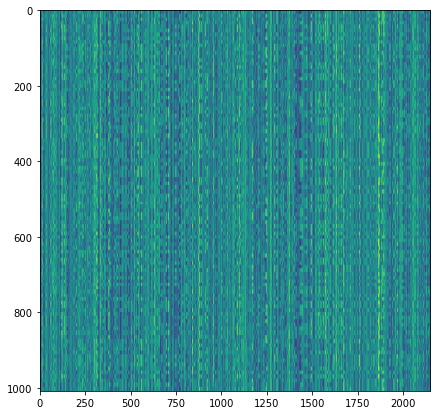

In [183]:
fig,ax = plt.subplots(figsize=(7,7))
ax.imshow(X, aspect='auto')
plt.show()

100%|██████████| 1008/1008 [05:22<00:00,  3.13it/s]


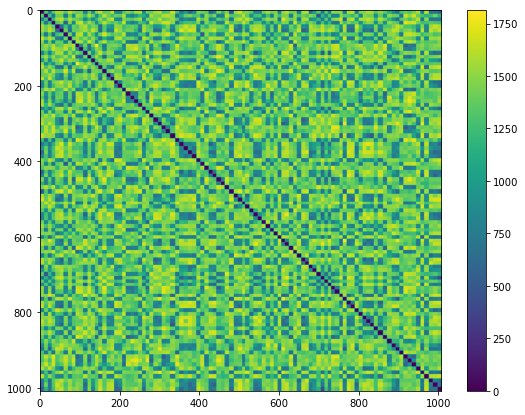

In [184]:
def hamming(g0, g1):
    n_mismatches = 0
    for i, j in zip(g0, g1):
        if i != j: n_mismatches += 1
    return n_mismatches

# Hamming distance all-vs-all matrix
distX = np.zeros((X.shape[0],X.shape[0]))
for i in tqdm(range(X.shape[0])):
    for j in range(X.shape[0]):
        distX[i,j] = hamming(X[i,:], X[j,:])

fig,ax = plt.subplots(figsize=(9,7))
h1 = ax.imshow(distX, aspect='auto')
fig.colorbar(h1, ax=ax)
plt.show()

  0%|          | 0/1008 [00:00<?, ?it/s]

(1008, 2151)
[[-1  7  1 ... -1  0 -1]
 [ 5 -1  1 ...  5  0  1]
 [-1 -1 -1 ... -1 -1  1]
 ...
 [-1  7  1 ...  5 -1  1]
 [ 5  7  1 ... -1 -1  1]
 [ 5  7 -1 ...  5  0 -1]]


100%|██████████| 1008/1008 [14:48<00:00,  1.14it/s]


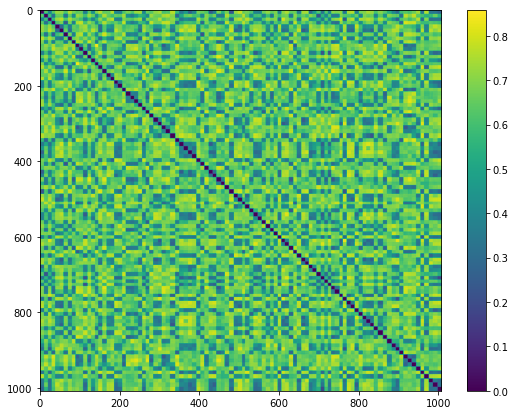

In [185]:
def adjustedHamming(s1, s2):
    if len(s1) != len(s2):
        raise ValueError("Sequence lengths unequal.")
    else:
        hd,adjlen = 0, 0
        for i, j in zip(s1, s2):
            if i == -1 or j == -1: 
                continue
            adjlen += 1
            if i != j: 
                hd += 1
        return hd, adjlen

# Introduce uniform dropout
n,m = X.shape
dropoutX = np.copy(X)
dropout = 0.3
for i in range(n):
    for j in range(m):
        if random.random() <= dropout:
            dropoutX[i,j] = -1

print(dropoutX.shape)
print(dropoutX)

# Hamming distance all-vs-all matrix
hd = np.zeros((n,n))
adjlen = np.zeros((n,n))
for i in tqdm(range(n)):
    for j in range(n):
        adjusted_hamming,length = adjustedHamming(dropoutX[i,:], dropoutX[j,:])
        hd[i,j] = adjusted_hamming
        adjlen[i,j] = length

ddistX = np.divide(hd,adjlen)
fig,ax = plt.subplots(figsize=(9,7))
h1 = ax.imshow(ddistX, aspect='auto')
fig.colorbar(h1, ax=ax)
plt.show()